In [3]:
# Import packages
import os
import matplotlib.pyplot as plt
import numpy as np
import inspect
import pandas as pd
import pickle
from scipy.stats import norm

from nilearn import image
from nilearn import plotting
from nilearn.glm.first_level import first_level_from_bids
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map
from nilearn.image import mean_img, get_data, math_img
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference

from atlasreader import create_output
from IPython.display import display, HTML
import glob

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [1]:
# Path to data and derivatives folders
data_dir='/work/fMRI_data/BIDS_2024E/' 
derivatives_dir= '/work/fMRI_data/BIDS_2024E/derivatives/'

In [15]:
# First Level Models from BIDS
task_label = 'boldiowa'
space_label ='MNI152NLin2009cAsym'

models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
    dataset_path = data_dir, 
    task_label = task_label, 
    space_label = space_label,
    derivatives_folder=derivatives_dir, 
    n_jobs=-2, 
    slice_time_ref = 0.462,
    verbose=False,
    img_filters=[("desc", "preproc")])

print(models[0:])

[FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0140', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0139', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0141', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0142', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0138', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0136', t_r=1,
                verbose=False)]


In [7]:
# FLM default arguments
args=inspect.getfullargspec(first_level_from_bids)
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)
print(models[0])

                                        0
space_label                          None
sub_labels                           None
img_filters                          None
t_r                                  None
slice_time_ref                        0.0
hrf_model                          glover
drift_model                        cosine
high_pass                            0.01
drift_order                             1
fir_delays                            [0]
min_onset                             -24
mask_img                             None
target_affine                        None
target_shape                         None
smoothing_fwhm                       None
memory              Memory(location=None)
memory_level                            1
standardize                         False
signal_scaling                          0
noise_model                           ar1
verbose                                 0
n_jobs                                  1
minimize_memory                   

In [8]:
# fMRI dimensions
func01=([os.path.basename(run) for run in models_run_imgs[0]])
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
func_img = image.load_img(func01_path)
func_hdr = func_img.header

In [13]:
print(f"Shape of fMRI {func_img.shape}")
print(f"Voxel dimensions and sampling rate {func_hdr.get_zooms()}")
print(f"Units {func_hdr.get_xyzt_units()}")

Shape of fMRI (78, 92, 78, 2400)
Voxel dimensions and sampling rate (2.526, 2.526, 2.5, 1.0)
Units ('mm', 'sec')


In [16]:
# Subset selected confounds (Friston24 and Global Signal)
confound_friston24_GSR = [
    'global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2',
    'trans_x','trans_y','trans_z',
    'rot_x','rot_y','rot_z',
    'trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
    'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
    'trans_x_power2','trans_y_power2','trans_z_power2',
    'rot_x_power2','rot_y_power2','rot_z_power2']

for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1
print(models_confounds[0][0].columns)

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1',
       'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1',
       'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2',
       'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2'],
      dtype='object')


In [17]:
# View all logged event names
print(models_events[0][0].columns)

Index(['onset', 'duration', 'win', 'loss', 'total', 'trial_type', 'response',
       'n_moves', 'RT', 'run', 'ID', 'task'],
      dtype='object')


In [21]:
# Subset relevant events 
events_sub= ['onset','duration','trial_type']

# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1
print(models_events[0][0])
print(models_events[0][0]['trial_type'].value_counts())

         onset  duration trial_type
0     0.987188       5.0      decks
1    15.975828       5.0      decks
2    30.976472       5.0      decks
3    45.977208       5.0      decks
4    60.977888       5.0      decks
..         ...       ...        ...
75  533.548860       2.0        win
76  548.549543       2.0        win
77  563.550245       2.0        win
78  578.550945       2.0        win
79  593.551717       2.0        win

[80 rows x 3 columns]
trial_type
decks      40
win        30
loss        7
neutral     3
Name: count, dtype: int64


In [22]:
# Fit one FLM on the contrast wins-lossses 
model1=models[0]
imgs1=models_run_imgs[0]
events1=models_events[0]
confounds1=models_confounds[0]

/tmp/ipykernel_10409/2999785780.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  model1.zmap=model1.compute_contrast('win-loss')


In [24]:
# Define design matrix and contrasts and signifcance threshold
design_matrix = model1.design_matrices_[0]
contrasts=['decks','win','loss','neutral', 'win-neutral','win-loss', 'loss-neutral']
p001_unc = norm.isf(0.001)

/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


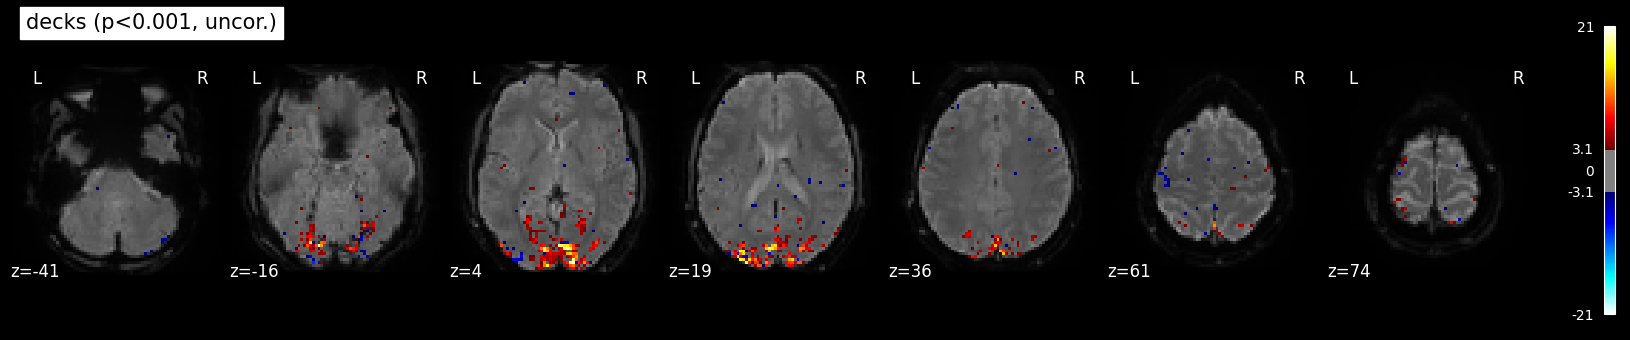

   Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0           1  14.644001 -97.136000   4.0  20.627905              27054
1          1a -15.667999 -81.980000 -16.0  19.986515                   
2          1b -20.719999 -99.662000  14.0  19.318874                   
3          1c   9.592001 -84.506000   4.0  18.841051                   
4           2   7.066001 -92.084000  31.5  14.587128               2233
5          2a  19.696001 -87.032000  21.5  13.778972                   
6          2b  29.800001 -87.032000  24.0  12.602815                   
7          2c  17.170001 -87.032000  26.5  12.014722                   
8           3  -5.563999 -81.980000  49.0   9.987657                877
9          3a -23.245999 -81.980000  49.0   9.562092                   
10         3b -25.771999 -74.401999  39.0   8.833813                   
11         3c -15.667999 -84.506000  51.5   7.827091                   
12          4 -43.454000 -87.032000  -6.0   9.854027            

/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


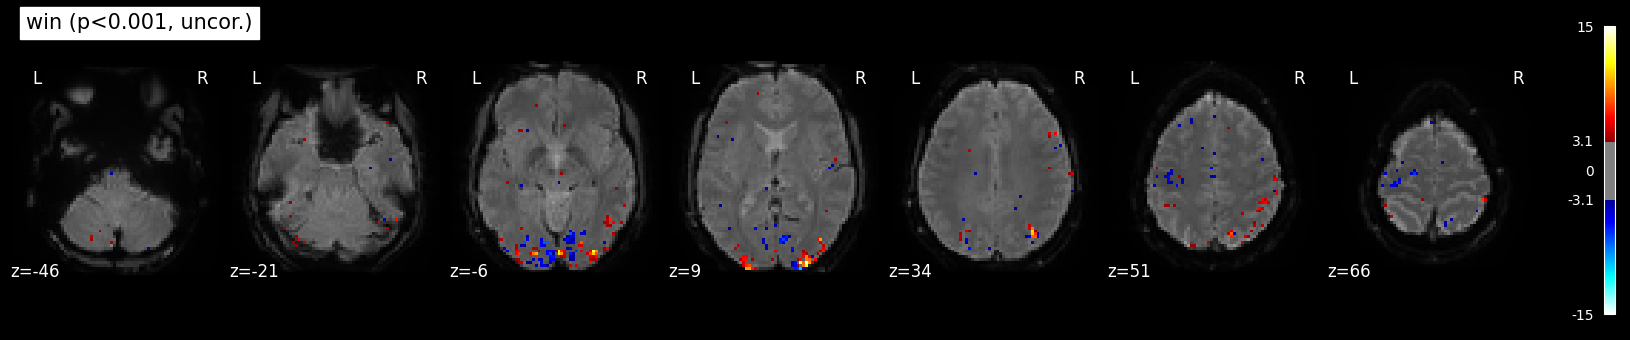

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1  27.274001  -97.136000   9.0  15.055450               1148
1          1a  27.274001  -99.662000  -1.0  10.838068                   
2          1b  19.696001  -97.136000  19.0   9.215163                   
3          1c  24.748001  -92.084000   6.5   9.053124                   
4           2 -23.245999 -102.188000   6.5  14.884957                542
5          2a -30.823999  -97.136000   6.5   7.048101                   
6           3  32.326001  -87.032000  -6.0  12.157094                973
7          3a  42.430001  -79.454000 -13.5   9.393044                   
8          3b  29.800001  -97.136000  -6.0   5.870928                   
9           4   2.014001  -87.032000  -8.5  11.878452                334
10          5  32.326001  -69.349999  34.0  10.461533                510
11         5a  29.800001  -79.454000  46.5   5.800882                   
12          6  37.378001  -79.454000   4.0   9.6671

/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


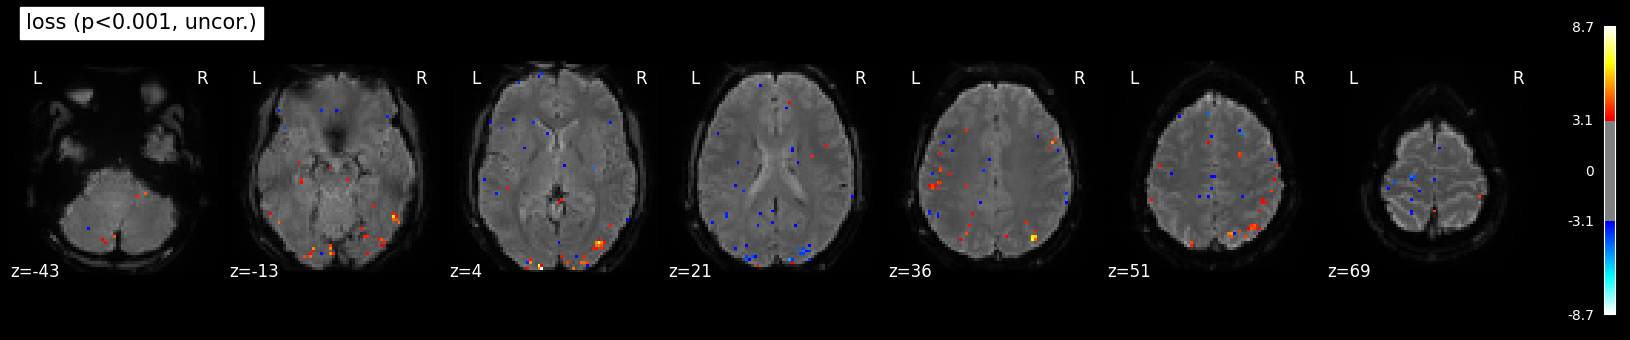

   Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0           1  27.274001 -97.136000   9.0   7.481491                446
1          1a  27.274001 -99.662000  -1.0   6.703852                   
2           2   2.014001 -89.558000  -6.0   7.282306                350
3          2a  -0.511999 -81.980000 -11.0   4.210735                   
4           3  32.326001 -76.927999  36.5   6.681791                446
5          3a  32.326001 -66.823999  26.5   5.015392                   
6          3b  32.326001 -76.927999  26.5   3.578496                   
7           4 -23.245999 -74.401999  49.0   4.688971                430
8          4a -25.771999 -66.823999  44.0   4.266922                   
9          4b -23.245999 -81.980000  49.0   4.248931                   
10         4c -23.245999 -66.823999  39.0   4.082662                   


/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


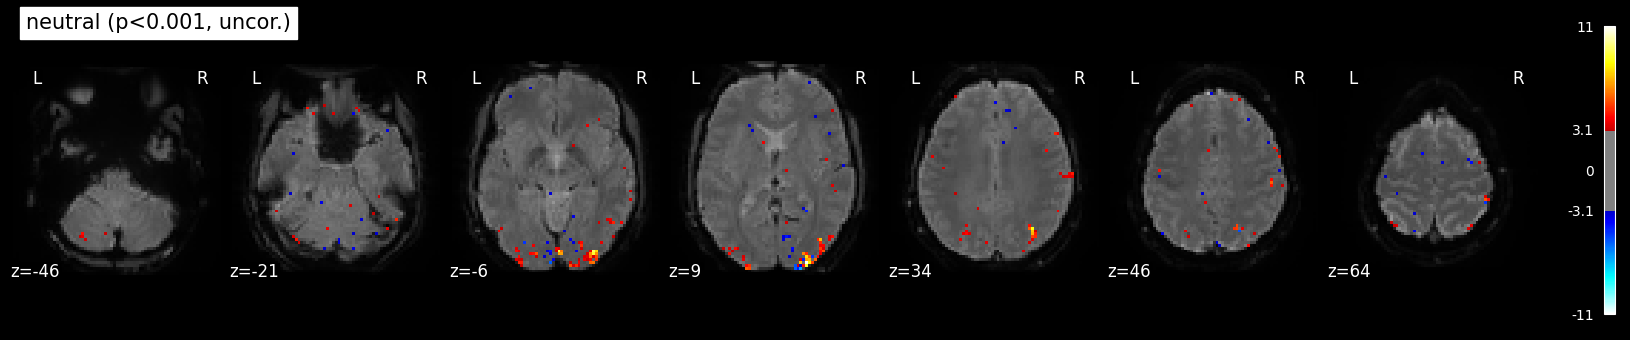

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1  27.274001  -97.136000   9.0  11.050076                813
1          1a  27.274001  -99.662000  -1.0   7.622257                   
2          1b  22.222001  -94.610000  14.0   6.806485                   
3           2  34.852001  -87.032000  -8.5  10.102812               1068
4          2a  32.326001  -97.136000  -6.0   5.905654                   
5          2b  34.852001  -94.610000   9.0   5.732468                   
6          2c  12.118001  -99.662000  -6.0   5.298766                   
7           3 -23.245999 -102.188000   6.5   9.737946                414
8          3a -30.823999  -97.136000   6.5   6.322456                   
9          3b -20.719999  -94.610000   6.5   3.954901                   
10          4  32.326001  -66.823999  34.0   8.297553                478
11         4a  32.326001  -76.927999  36.5   6.755766                   
12          5  39.904001  -84.506000   6.5   8.0696

/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


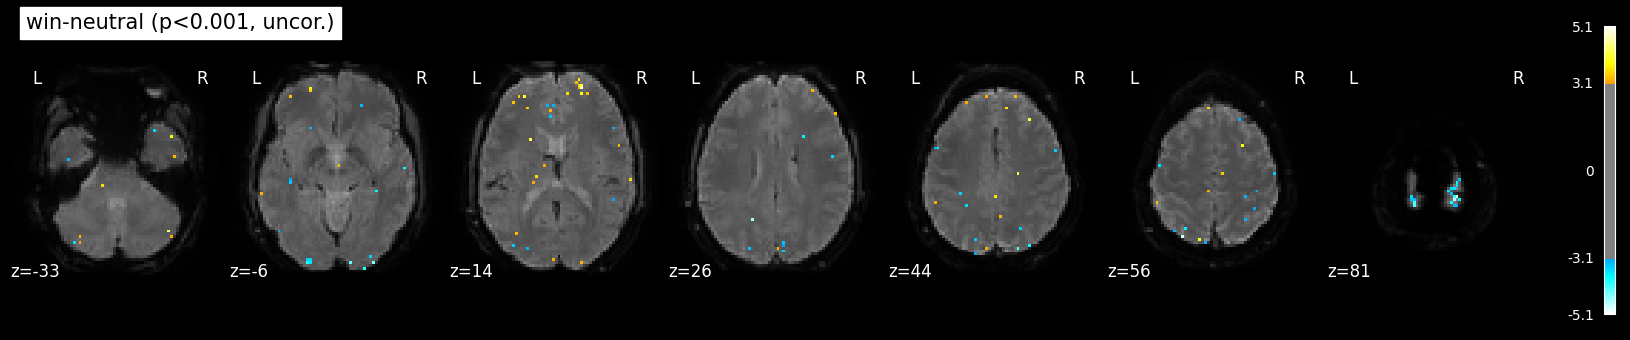

/tmp/ipykernel_10409/4274569410.py:11: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  table = get_clusters_table(z_map, stat_threshold=p001_unc,
/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


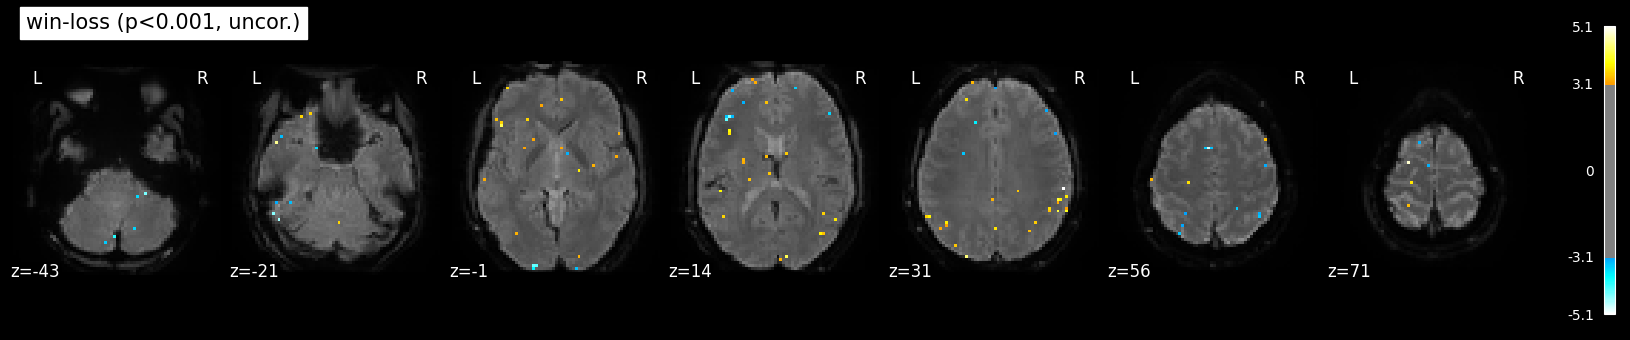

/tmp/ipykernel_10409/4274569410.py:11: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  table = get_clusters_table(z_map, stat_threshold=p001_unc,
/tmp/ipykernel_10409/4274569410.py:5: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


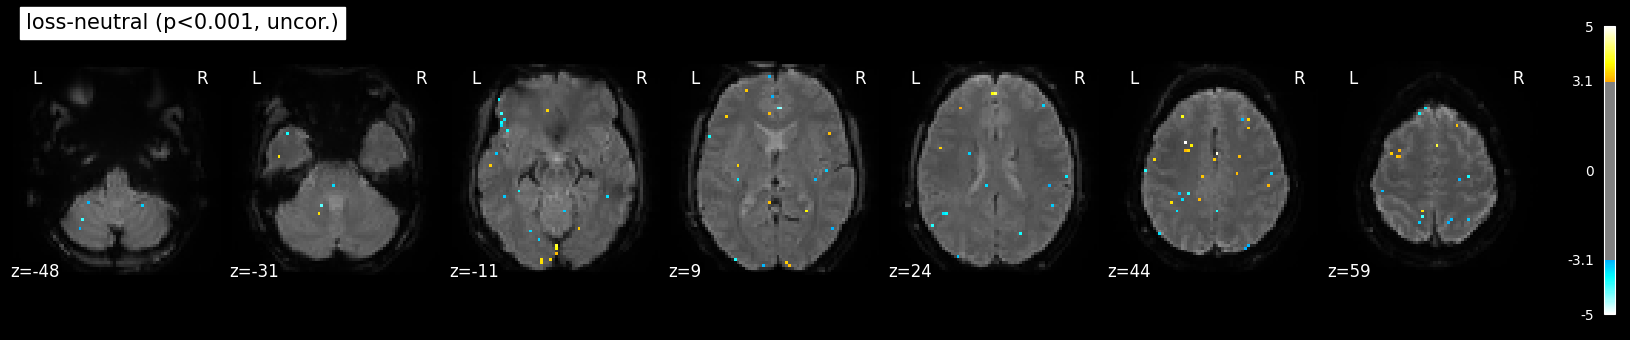

Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


/tmp/ipykernel_10409/4274569410.py:11: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  table = get_clusters_table(z_map, stat_threshold=p001_unc,


In [25]:
# Fit model on contrasts and plot contrast results
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score')
    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)

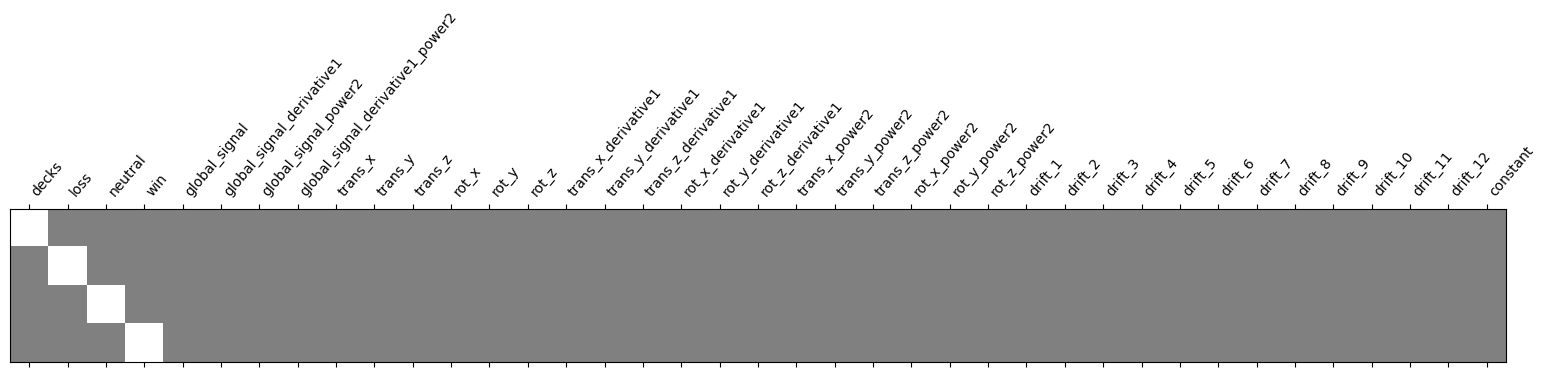

/tmp/ipykernel_10409/886483867.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(effects_of_interest,
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/nilearn/glm/contrasts.py:159: UserWarning: Running approximate fixed effects on F statistics.
  contrast = contrast_ if contrast is None else contrast + contrast_


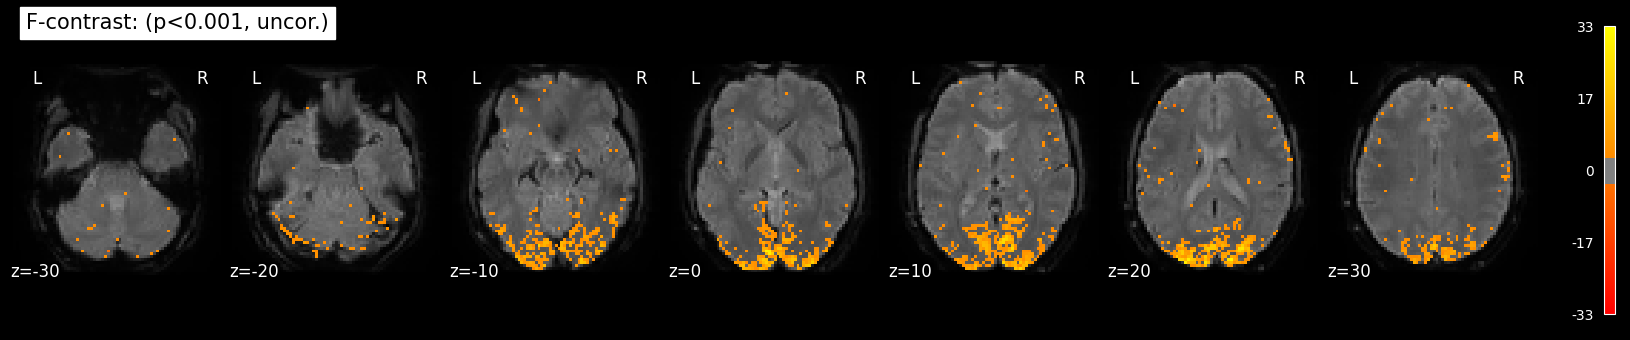

In [26]:
#F-contrast
effects_of_interest =np.identity(design_matrix.shape[1])[[0,1,2,3],:]

#Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

#Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

#And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()